In [1]:
#pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score
from wordcloud import WordCloud 

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10065] A socket operation was attempted to an unreachable host
  % (host, default, e), RuntimeWarning)


In [2]:
df= pd.read_csv("train_E6oV3lV.csv")

In [3]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [6]:
#remove username starting with @
df['clean_tweet']= df['tweet'].replace(r'@\w+','',regex=True)

In [7]:
def decontracted(phrase):
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#remove apostrphe from the word
df['clean_tweet']= [decontracted(i) for i in df['clean_tweet']]

In [8]:
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i ca not use cause t...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [9]:
#remove RT(retweet) 
df['clean_tweet'].replace('RT','',regex=True, inplace= True)

# Removing the links present in our clean text 
df['clean_tweet'].replace('((www\.[^\s]+)|(https?://[^\s]+))', '\0', inplace=True, regex=True)

#Removing # from words
df['clean_tweet']= df['clean_tweet'].replace(r'#','',regex=True)

# Removing special characters, numbers, punctuations as none of them would add any value while making sentiment analysis
df['clean_tweet'].replace('[^a-zAA-Z]+', ' ', inplace=True, regex=True)

#Removing the word 'hmm' and it's variants
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word == 'h(m)+' ]))

# Converting all the clean_text column into lower case
df['clean_tweet'] = df['clean_tweet'].str.lower()

In [10]:
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i ca not use cause they...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation


In [11]:
df['tweet'][0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [12]:
df['clean_tweet'][0]

'when a father is dysfunctional and is so selfish he drags his kids into his dysfunction run'

In [13]:
#Code for removing slang words
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food'} ## Need a huge dictionary
words = "I luv myself"
words = words.split()
reformed = [d[word] if word in d else word for word in words]
reformed = " ".join(reformed)
reformed

'I love myself'

In [14]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join(d[word] if word in d else word for word in x.split()))

In [15]:
# TOKENIZATION
# Splitting each row of clean_text column into list of words
df['clean_tweet'] = df['clean_tweet'].str.split()

df['clean_tweet']

0        [when, a, father, is, dysfunctional, and, is, ...
1        [thanks, for, lyft, credit, i, ca, not, use, c...
2                                  [bihday, your, majesty]
3        [model, i, love, u, take, with, u, all, the, t...
4                   [factsguide, society, now, motivation]
5        [huge, fan, fare, and, big, talking, before, t...
6                               [camping, tomorrow, danny]
7        [the, next, school, year, is, the, year, for, ...
8        [we, won, love, the, land, allin, cavs, champi...
9                   [welcome, here, i, am, it, is, so, gr]
10       [ireland, consumer, price, index, mom, climbed...
11       [we, are, so, selfish, orlando, standwithorlan...
12       [i, get, to, see, my, daddy, today, days, gett...
13       [cnn, calls, michigan, middle, school, build, ...
14       [no, comment, in, australia, opkillingbay, sea...
15       [ouch, junior, is, angry, got, junior, yugyoem...
16       [i, am, thankful, for, having, a, paner, thank.

In [16]:
# Getting list of stopwords present in the nltk library
stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')

In [17]:
# Removing the stopwords from every row of the column 'clean_text'
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:[item for item in x if item not in stop_words])

df['clean_tweet']

0        [father, dysfunctional, selfish, drags, kids, ...
1        [thanks, lyft, credit, ca, not, use, cause, no...
2                                        [bihday, majesty]
3                      [model, love, u, take, u, time, ur]
4                        [factsguide, society, motivation]
5        [huge, fan, fare, big, talking, leave, chaos, ...
6                               [camping, tomorrow, danny]
7        [next, school, year, year, exams, ca, not, thi...
8        [love, land, allin, cavs, champions, cleveland...
9                                            [welcome, gr]
10       [ireland, consumer, price, index, mom, climbed...
11       [selfish, orlando, standwithorlando, pulseshoo...
12              [get, see, daddy, today, days, gettingfed]
13       [cnn, calls, michigan, middle, school, build, ...
14       [no, comment, australia, opkillingbay, seashep...
15       [ouch, junior, angry, got, junior, yugyoem, oh...
16                   [thankful, paner, thankful, positiv

In [18]:
# Joining all the tokens into a string
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join(x))

df['clean_tweet']

0        father dysfunctional selfish drags kids dysfun...
1        thanks lyft credit ca not use cause not offer ...
2                                           bihday majesty
3                              model love u take u time ur
4                            factsguide society motivation
5        huge fan fare big talking leave chaos pay disp...
6                                   camping tomorrow danny
7        next school year year exams ca not think schoo...
8        love land allin cavs champions cleveland cleve...
9                                               welcome gr
10       ireland consumer price index mom climbed previ...
11       selfish orlando standwithorlando pulseshooting...
12                     get see daddy today days gettingfed
13       cnn calls michigan middle school build wall ch...
14       no comment australia opkillingbay seashepherd ...
15            ouch junior angry got junior yugyoem oh god!
16                        thankful paner thankful positi

Normal words


(-0.5, 799.5, 499.5, -0.5)

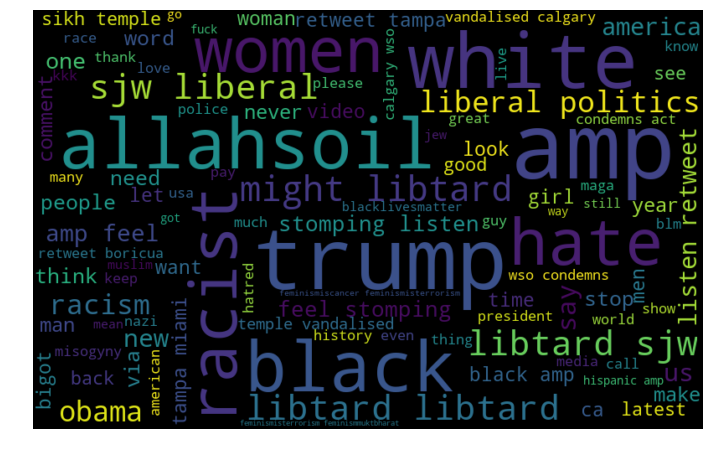

In [19]:
normal_words = ' '.join([word for word in df['clean_tweet'][df['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

Normal words


(-0.5, 799.5, 499.5, -0.5)

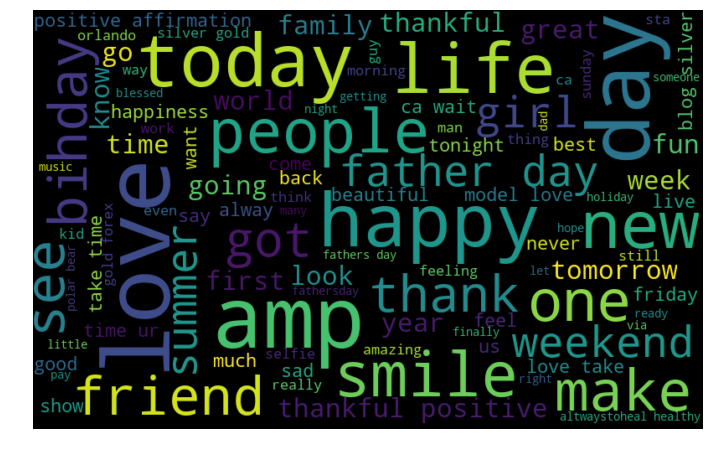

In [20]:
normal_words = ' '.join([word for word in df['clean_tweet'][df['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

In [21]:
cv= CountVectorizer(max_features = 3500)
x=cv.fit_transform(df['clean_tweet']).toarray()

In [22]:
x.shape

(31962, 3500)

In [23]:
y= df['label']

In [24]:
y.shape

(31962,)

In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 3500)
(7991, 3500)
(23971,)
(7991,)


In [26]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [27]:
model1 = LogisticRegression()
model1.fit(x_train, y_train)

y_pred1 = model1.predict(x_valid)

print("Logistic Regression:")
print("Training Accuracy :", model1.score(x_train, y_train))
print("Validation Accuracy :", model1.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred1))
print('--------------------------------------------------')

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression:
Training Accuracy : 0.9924074923866338
Validation Accuracy : 0.9260417970216493
F1 score : 0.5371965544244323
--------------------------------------------------


In [ ]:
model2 = DecisionTreeClassifier()
model2.fit(x_train, y_train)

y_pred2 = model2.predict(x_valid)

print("Decision Tree Classifier:")
print("Training Accuracy :", model2.score(x_train, y_train))
print("Validation Accuracy :", model2.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred2))
print('--------------------------------------------------')

In [ ]:
model6 = GaussianNB()
model6.fit(x_train, y_train)

y_pred6 = model6.predict(x_valid)

print("Naive Bayes Classifier:")
print("Training Accuracy :", model6.score(x_train, y_train))
print("Validation Accuracy :", model6.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred6))
print('--------------------------------------------------')

In [ ]:
model3 = RandomForestClassifier(n_estimators=35,n_jobs=-1, random_state=30)
model3.fit(x_train, y_train)

y_pred3 = model3.predict(x_valid)

print("Random Forest Classifier:")
print("Training Accuracy :", model3.score(x_train, y_train))
print("Validation Accuracy :", model3.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred3))
print('--------------------------------------------------')

In [ ]:
model5 =  XGBClassifier()
model5.fit(x_train, y_train)

y_pred5 = model5.predict(x_valid)

print("Grdient Boosting:")
print("Training Accuracy :", model5.score(x_train, y_train))
print("Validation Accuracy :", model5.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred5))
print('--------------------------------------------------')

#### Test Data

In [ ]:
df_test= pd.read_csv("test_tweets_anuFYb8.csv")

In [ ]:
df_test.head()

In [ ]:
df_test['clean_tweet']= df_test['tweet'].replace(r'@\w+','',regex=True)

In [ ]:
df_test['clean_tweet']= [decontracted(i) for i in df_test['clean_tweet']]

In [ ]:
#remove RT(retweet) 
df_test['clean_tweet'].replace('RT','',regex=True, inplace= True)

# Removing the links present in our clean text 
df_test['clean_tweet'].replace('((www\.[^\s]+)|(https?://[^\s]+))', '\0', inplace=True, regex=True)

# Removing special characters, numbers, punctuations as none of them would add any value while making sentiment analysis
df_test['clean_tweet'].replace('[^a-zAA-Z]+', ' ', inplace=True, regex=True)

#Removing the word 'hmm' and it's variants
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word == 'h(m)+' ]))

# Converting all the clean_text column into lower case
df_test['clean_tweet'] = df_test['clean_tweet'].str.lower()

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda x : ' '.join(d[word] if word in d else word for word in x.split()))

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].str.split()

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda x:[item for item in x if item not in stop_words])

In [ ]:
df_test['clean_tweet'] = df_test['clean_tweet'].apply(lambda x: ' '.join(x))

In [ ]:
xtest=cv.fit_transform(df_test['clean_tweet']).toarray()

In [ ]:
x_test= sc.transform(xtest)

In [ ]:
pred = model3.predict(x_test)

In [ ]:
prediction= pd.Series(pred)

In [ ]:
df1= pd.concat([df_test['id'],prediction],axis=1)

In [ ]:
df1.columns=['id','label']

In [ ]:
df1.head()

In [ ]:
df1.label.value_counts()

In [ ]:
df1.to_csv("Twitter_solution.csv", index= False)